In [625]:
import pandas as pd
import geopandas as gpd
import datetime as dt
import numpy as np
import math
from haversine import haversine
from scipy.optimize import minimize, Bounds
from scipy.stats import norm
from scipy.spatial.distance import directed_hausdorff
from shapely.geometry import Polygon, MultiPolygon
from matplotlib import pyplot as plt, ticker
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, KFold

In [ ]:
fortaleza = gpd.read_file('Dados/Densidade_Populacional_por_Bairros.zip')

In [ ]:
def arred_baixo(num, dec):
    return math.floor(num * 10 ** dec) / 10 ** dec

In [ ]:
def criar_celula(lat, lng, passo):
    return Polygon([(lat, lng), (lat + passo, lng), (lat + passo, lng + passo), (lat, lng + passo)])

In [ ]:
x_min, y_min, x_max, y_max = (arred_baixo(b, 2) for b in fortaleza.geometry.unary_union.bounds)

In [ ]:
p = 0.01

In [ ]:
grade_completa = MultiPolygon((criar_celula(x, y, p) for x in np.arange(x_min - p, x_max + p, p) for y in np.arange(y_min - p, y_max + p, p)))   

In [ ]:
grade_fortaleza = MultiPolygon([c for c in grade_completa.geoms if c.intersects(fortaleza.unary_union)])

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

fortaleza.plot(ax=ax1)
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())
gpd.GeoSeries(grade_fortaleza).boundary.plot(ax=ax2)

In [134]:
entregas = pd.read_csv('Dados/New_query_2023_07_15.csv', parse_dates=['event_day', 'event_timestamp', 'event_timestamp_hour']).sort_values('event_timestamp')

In [137]:
entregas_por_rest = entregas.groupby('frn_id')['order_id'].nunique().reset_index()

In [138]:
tamanho_amostra = 1

In [139]:
rests_amostra = entregas_por_rest[entregas_por_rest.order_id > 100][['frn_id']].drop_duplicates().sample(n=tamanho_amostra, random_state=123)

In [159]:
entregas_amostra = entregas.merge(rests_amostra, on='frn_id')

In [160]:
inicio_fim_rotas = entregas_amostra.groupby('route_id', as_index=False).agg({'event_timestamp': ['min', 'max']}).droplevel(0, 1).rename({'': 'route_id', 'min': 'inicio_rota', 'max': 'fim_rota'}, axis='columns')

In [161]:
entregas_amostra = entregas_amostra.merge(inicio_fim_rotas, how='inner', on='route_id')

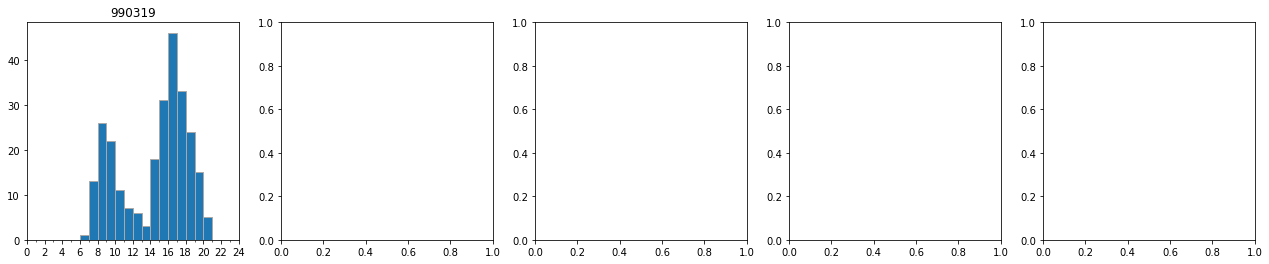

In [165]:
fig, axs = plt.subplots(nrows=max(1, math.floor(tamanho_amostra / 5)), ncols=5, figsize=(22, 4))
grupos_rests = entregas_amostra.groupby('frn_id')

for (grp, df), ax in zip(grupos_rests, axs.ravel()):
    df[['event_timestamp_hour', 'order_id']].drop_duplicates()['event_timestamp_hour'].dt.hour.plot(kind='hist', bins=range(24), edgecolor='darkgrey', ax=ax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.set_xlim((0, 24))
    ax.set_ylabel('')
    ax.set_title(grp)

In [125]:
def montar_janela(t0, m, delta_t):
    """
    Obtém uma janela de m datetimes iniciando em t0 e saltando a cada delta_t
    
    :param t0: momento inicial da janela
    :param m: número de momentos que compõem a janela
    :param delta_t: tamanho do salto de tempo entre cada momento t
    :returns: uma lista de momentos compondo uma janela
    """
    return [t0 + dt.timedelta(minutes=m) for m in range(0, m * delta_t, delta_t)]

In [239]:
def configurar_janela(df, att, fim, obj, lat, lng, t0, m, delta_t):
    """
    Obtém a configuração de estado de cada momento de uma janela
    
    :param df: dataframe com os dados para popular a janela
    :param att: coluna com as atualizações de cada evento
    :param fim: coluna com o término de cada evento
    :param obj: coluna com o objeto que nasce/morre/move
    :param lat: coluna com as latitudes do evento
    :param lng: coluna com as longitudes do evento
    :param t0: momento inicial da janela
    :param m: número de momentos que compõem a janela
    :param delta_t: tamanho do salto de tempo entre cada momento t
    :returns: uma janela com suas configurações em cada momento t
    """
    j = montar_janela(t0, m, delta_t)
    X = []

    for t in j:
        objs_vivos = df[(df[att] <= t) & (df[fim] > t)]
        ids = objs_vivos[obj].unique()
        coords = objs_vivos.drop_duplicates(subset=[obj], keep='last')[[lat, lng]].to_numpy()
        X.append({'t': t, 'n': len(coords), 'id': ids, 'xy': coords})
        
    return X

In [240]:
janela = configurar_janela(entregas_amostra, 'event_timestamp', 'fim_rota', 'driver_uuid', 'drv_lat', 'drv_lng', dt.datetime(2023, 1, 10, 17, 0, 0, 0), 30, 2)

In [224]:
matriz_hausdorff = []

for i in janela:
    linha = []
    for j in janela:
        if i['t'] != j['t']:
            matriz_haversine = np.array([np.array([haversine(k, l) for l in j['xy']]) for k in i['xy']])
            dist = np.max(np.concatenate((np.amin(matriz_haversine, axis=1), np.amin(np.transpose(matriz_haversine), axis=1))))
        else:
            dist = 0
        
        linha.append(dist)
    matriz_hausdorff.append(np.array(linha))
    
matriz_hausdorff = np.array(matriz_hausdorff)

In [275]:
nascimentos = [len(np.setdiff1d(j['id'], i['id'])) for (i, j) in zip(janela[:-1] , janela[1:])]

In [276]:
mortes = [len(np.setdiff1d(i['id'], j['id'])) for (i, j) in zip(janela[:-1] , janela[1:])]

In [311]:
teste = [[0.        , 0.9550354 , 1.71911205, 2.56960031],
       [0.9550354 , 0.        , 1.81535691, 1.80652697],
       [1.71911205, 1.81535691, 0.        , 0.85528255],
       [2.56960031, 1.80652697, 0.85528255, 0.        ]]

In [725]:
def estimador_alfa(dn, dt, h, matriz_dist,K=norm.pdf):
    Kt = K(matriz_dist, 0, h).flatten()
    n = len(Kt) - 1
    Kt = np.delete(Kt, [n])
    t_chapeu = sum(Kt * dt)

    return np.sum(np.divide(np.resize(dn, n) * Kt, t_chapeu, where=t_chapeu != 0))

In [671]:
estimador_alfa(np.array([2, 3, 0]), 2, 0.85, teste)

[0.46934386 0.24966742 0.0607103  0.00486415 0.24966742 0.46934386
 0.04797589 0.04904953 0.0607103  0.04797589 0.46934386 0.2829023
 0.00486415 0.04904953 0.2829023  0.46934386]
5.596741510927227


0.7773060744675204

In [762]:
def log_verossimilhanca(h, janela, dn, dt, matriz_dist, K=norm.pdf):
    n = len(janela) - 1
    alfa_i = []
    
    for i in range(n):
        saltos_t = np.delete(dn, [i])
        dists_t = np.delete(matriz_dist[i], [i])
        alfa_i.append(estimador_alfa(saltos_t, dt, h, dists_t, K=K))
    print(h)
    return -np.sum(dn * np.log(alfa_i)) + np.sum(dt * alfa_i)

In [782]:
def maximizar_verossimilhanca(janela, dn, dt, matriz_dist, K=norm.pdf):
    iniciar = np.quantile(matriz_dist, 0.1) / 2
    maximo = np.max(matriz_dist)
    print(maximo)
    return minimize(fun=log_verossimilhanca, x0=np.array([iniciar]), args=(janela, dn, dt, matriz_dist, K), bounds=Bounds(0.0001, maximo))

In [783]:
maximizar_verossimilhanca(XX, np.array([2, 3, 0]), 2, teste)

2.56960031
[0.0001]
[0.00010001]


      fun: 15.723333880983944
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.0001])

In [703]:
minimize_scalar?

0.0
1.0
2.6180339999999998
1.0
1.6180339748439998
0.618034
0.381966025156
0.23606799039126328
0.145898044373474
0.11933913390882583
0.1311116075817107
0.1220780667769675
0.1170930262395384
0.07236747137892688
0.09253768203658413
0.08243683994561556
0.07734375901065778
0.07467550610079408
0.0730820430956858
0.07206406978068979
0.04453804530283883
0.07148694854196327
0.07128750611642018
0.07138722732919173
0.07134913721643422
0.07132559623168626
0.07131104710271853
0.0713020552463461
0.07129649797338482
0.07129306338974746
0.07129094070028373
0.0712896288060237
0.0712888180107666
0.07128831691173068
0.07128800721548911
0.07128781581268215
0.07128769751923975
0.07128762440987037
0.07128757922579437
0.07128755130049914
0.07128753404171724
0.07128752337520322
0.07128751678293489
0.07128751270868894
0.07128751019066641
0.07128750863444287
0.07128750756938775


     fun: 6.189069783783674
    nfev: 47
     nit: 43
 success: True
       x: 0.07128750756938775

In [715]:
minimize(fun=log_verossimilhanca, x0=(inicio,), args=(XX, np.array([2, 3, 0]), 2, teste, norm.pdf), bounds=Bounds(0.0001, maximo))

[0.0001]
[0.00010001]


      fun: 15.723333880983944
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.0001])

In [701]:
XX

[[[-3.809464, -38.554943],
  [-3.824826, -38.568384],
  [-3.809873, -38.559354],
  [-3.806728, -38.55403]],
 [[-3.809638, -38.554877],
  [-3.824406, -38.571757],
  [-3.809668, -38.554823],
  [-3.808754, -38.545415]],
 [[-3.818054, -38.556684],
  [-3.80957, -38.554689],
  [-3.803155, -38.538715],
  [-3.8094, -38.554823]],
 [[-3.8216, -38.555719],
  [-3.809448, -38.554679],
  [-3.800415, -38.531512],
  [-3.8094, -38.554825]]]

5.472673180890856

In [287]:
inicio

0.7157915882009936